## PINN

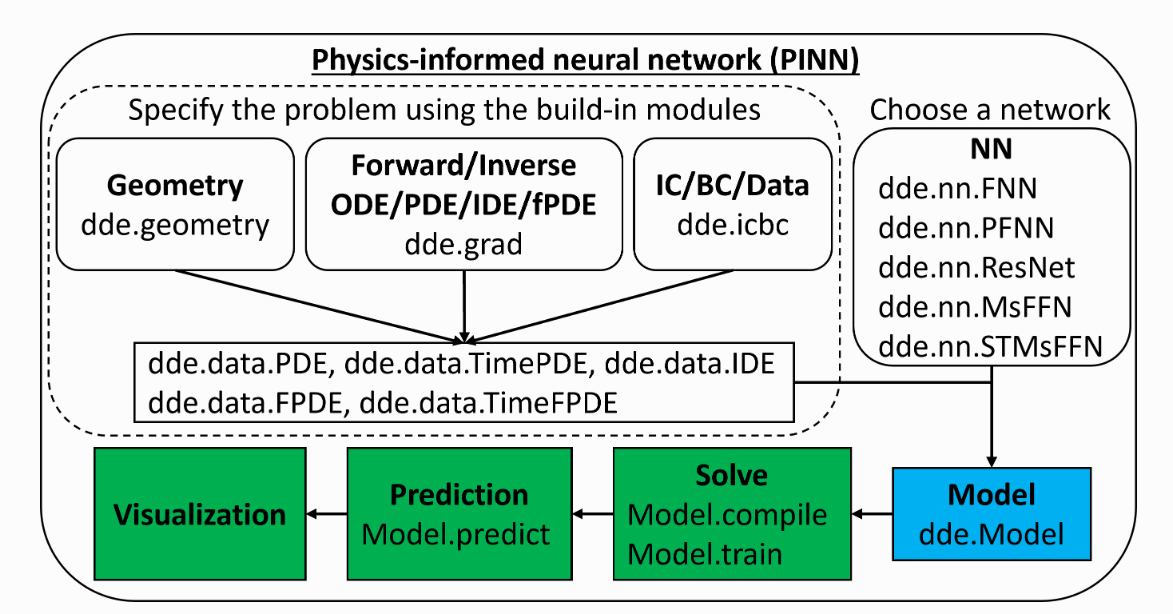

PINN 的思想是：利用神经网络来解微分方程（ODE/PDE/IDE/fPDE），在训练过程中不仅依赖数据，还把物理约束（方程、初边值条件等）加入损失函数里

dde.data.PDE, dde.data.TimePDE → 时间无关/时间相关的 PDE

dde.data.IDE → 积分微分方程

dde.data.FPDE, dde.data.TimeFPDE → 分数阶 PDE


dde.nn.FNN：全连接前馈神经网络（最常用）

dde.nn.PFNN：基于傅里叶特征的 PINN

dde.nn.ResNet：残差网络（深层网络更稳定）

dde.nn.MsFFN：多尺度前馈网络

dde.nn.STMsFFN：时空多尺度网络



**问题的构造部分（Specify the problem using the build-in modules）**

三个主要输入模块：

Geometry (dde.geometry)
定义问题的空间区域（如区间、矩形、圆域等），相当于 PDE 的定义域。

Forward/Inverse ODE/PDE/IDE/fPDE (dde.grad)
定义要求解的方程形式，可以是常微分方程 ODE、偏微分方程 PDE、积分微分方程 IDE，甚至分数阶微分方程 fPDE。

IC/BC/Data (dde.icbc)
初始条件（IC）、边界条件（BC）、以及可能存在的观测数据。

这三类信息合在一起，定义了 PINN 要解决的具体物理/数学问题.

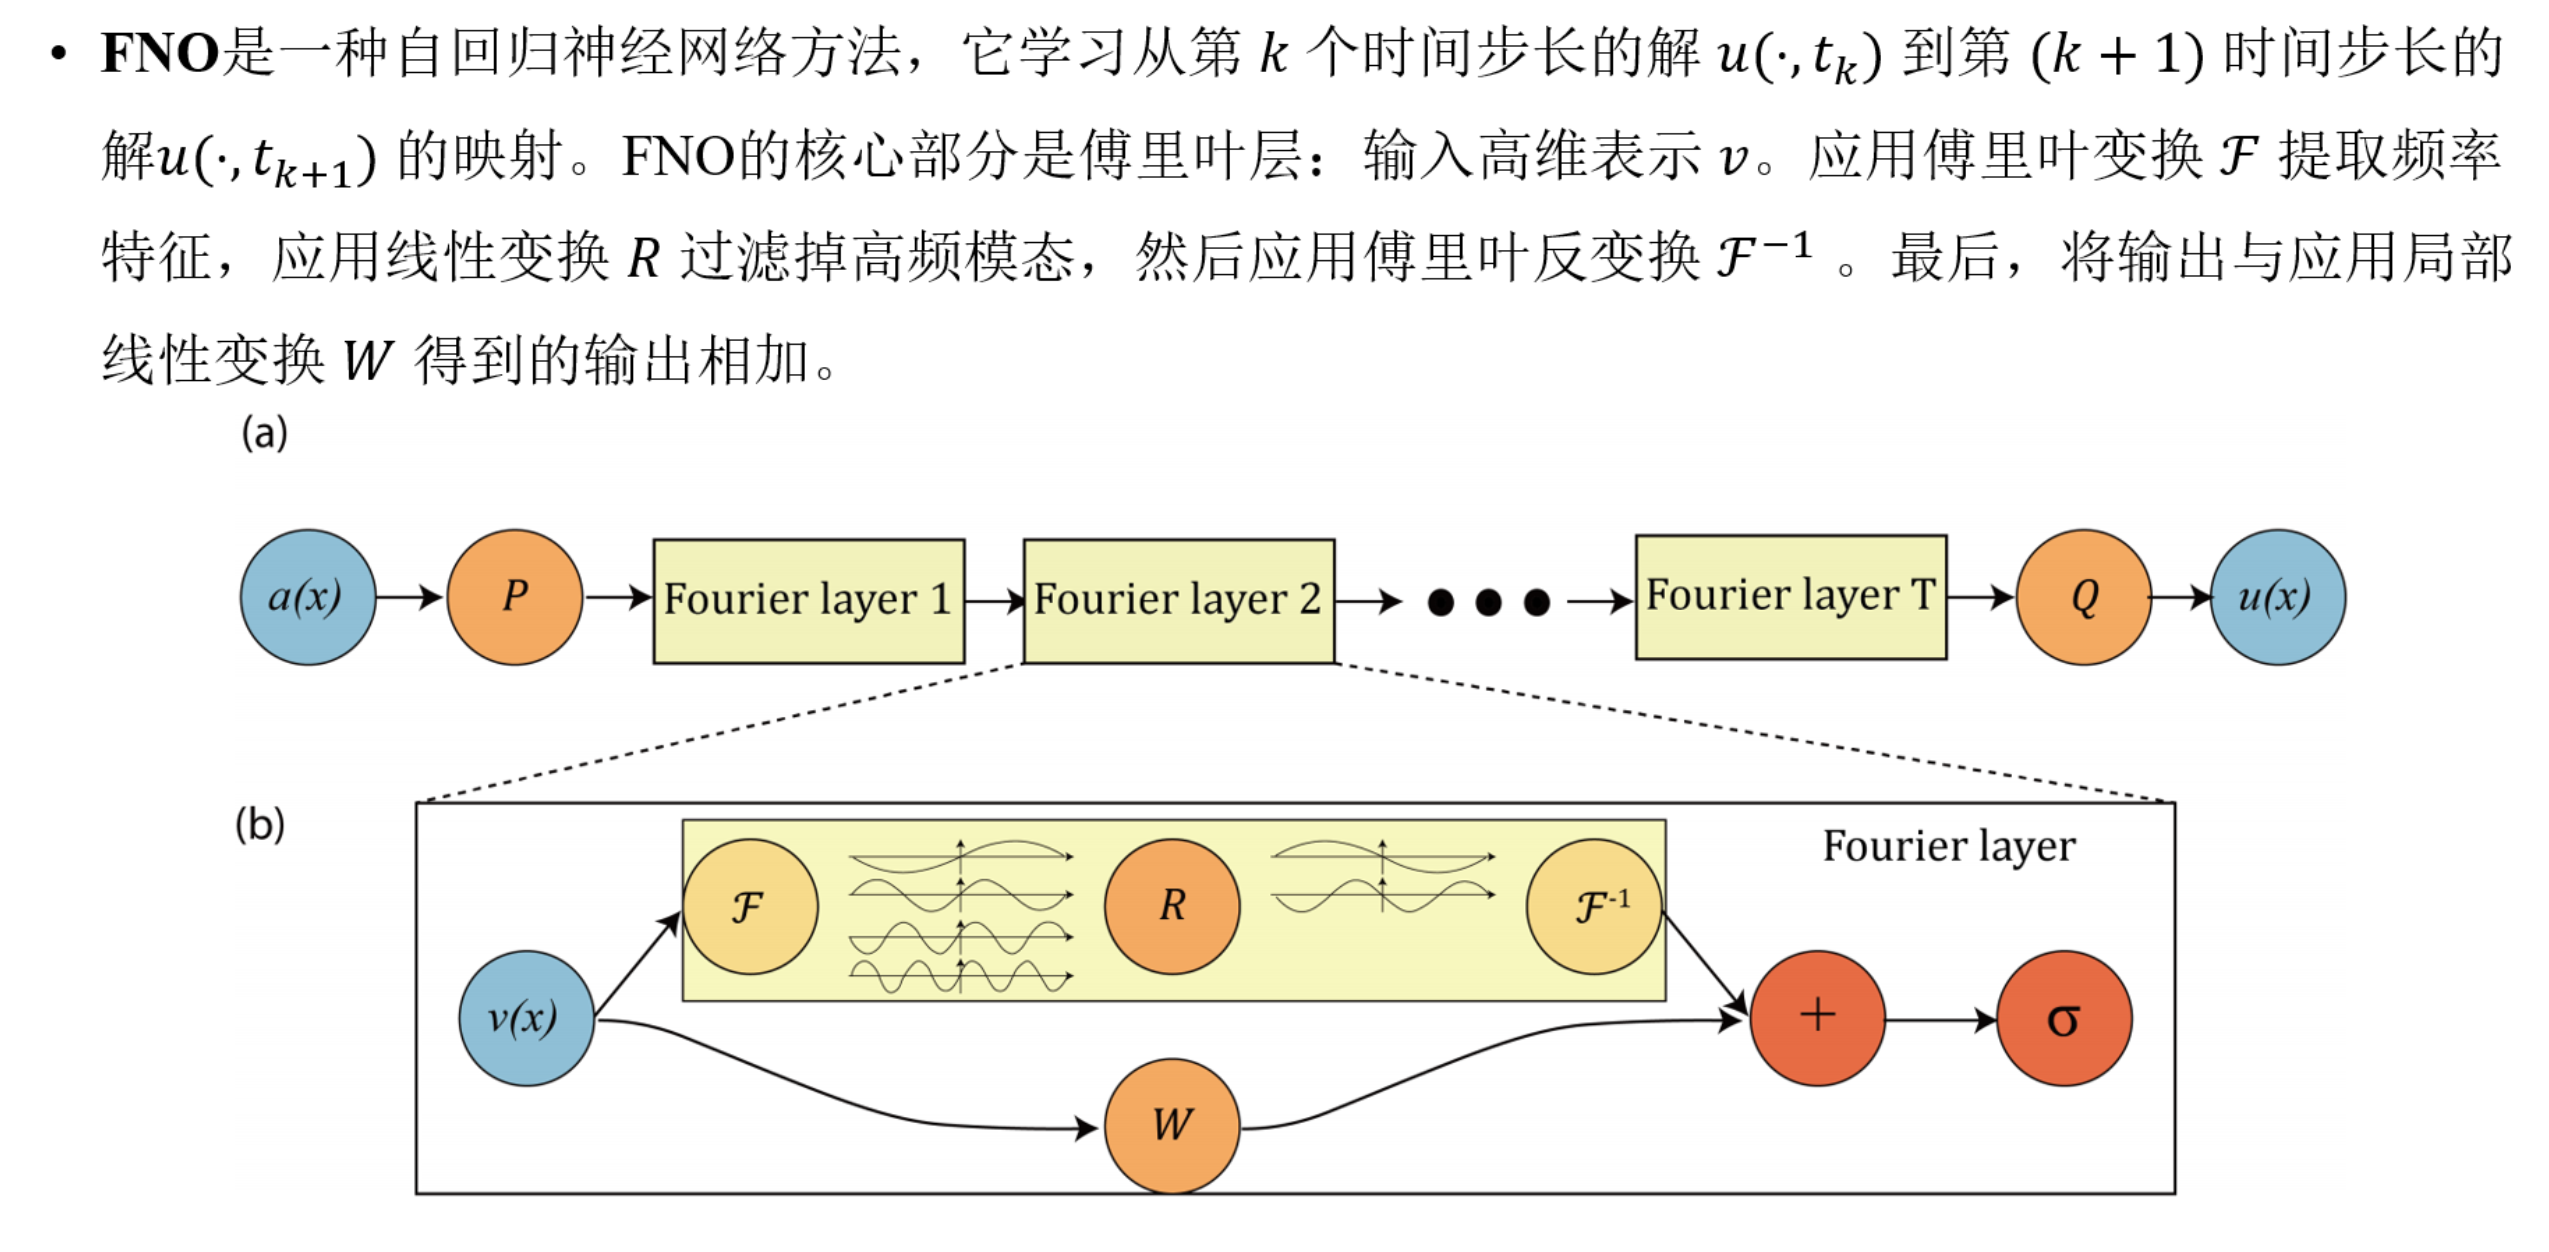

**FNO**首先输入a(x)：PDE的初始条件，系数场，或者其他输入函数；然后我们在P模块把输入投影到高维表述函数v(x)，这一步相当于embedding；然后经过多个fourier layer逐步提取解算子的特征；最后把结果投影回去输出解函数。

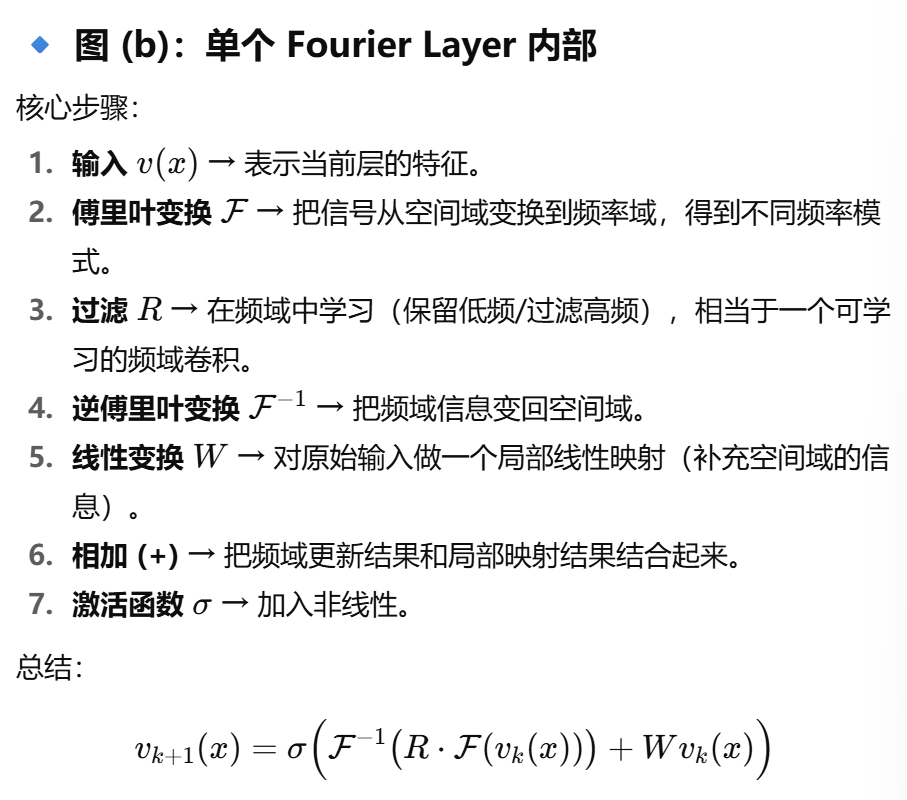



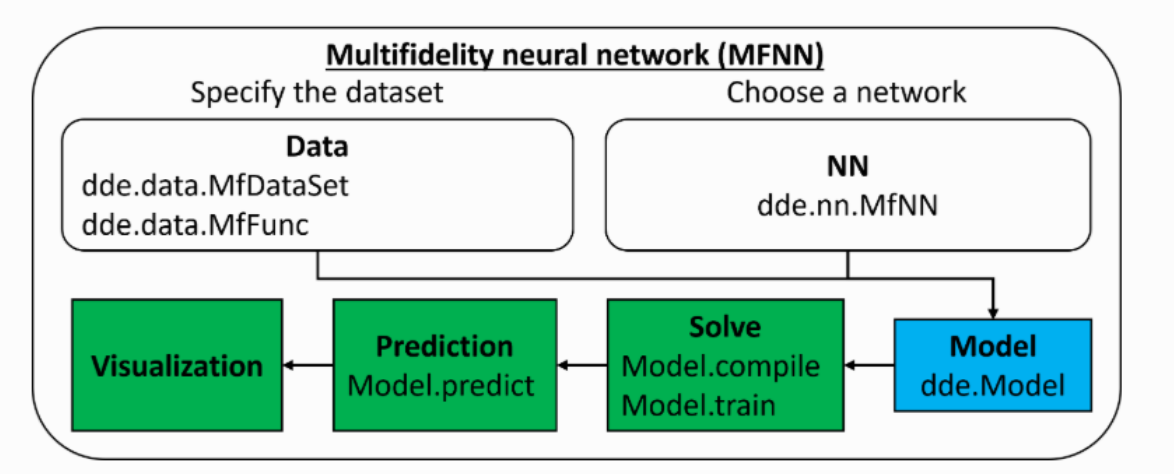
## ① 上半部分：MFNN 工作流

讲的是 **多保真神经网络 (MFNN, Multifidelity Neural Network)** 在 **DeepXDE** 里的用法。

* **Data**：

  * `dde.data.MfDataSet`——用已有的多保真数据集（如低保真模拟+高保真实验）。
  * `dde.data.MfFunc`——当你能按需调用“低/高保真函数”生成数据时用。
* **NN**：`dde.nn.MfNN`——多保真网络结构（通常两支/多支子网）：

  * 低保真子网学粗趋势 $y_L(x)$；
  * 高保真子网在此基础上学修正/映射，典型形式

    $$
    y_H(x)\approx \rho(x)\,y_L(x)+\delta(x)
    $$

    （$\rho,\delta$ 由子网学习）。
* **Model**：`dde.Model(data, net)` → `compile/train` 训练，`predict` 预测，最后做可视化。
  **用途**：融合“便宜但粗糙”的低保真与“昂贵但准确”的高保真信息，达到更好的精度/样本效率。

> 最小示例（两层保真）
>
> ```python
> data = dde.data.MfDataSet(X_lo, y_lo, X_hi, y_hi)
> net  = dde.nn.MfNN(
>   [ [X_lo.shape[1]] + [64,64] + [1],          # low-fidelity branch
>     [X_hi.shape[1]+1] + [64,64] + [1] ] )     # high-fidelity (输入含 x 与 y_L)
> model = dde.Model(data, net)
> model.compile("adam", lr=1e-3); model.train(epochs=..)
> ```

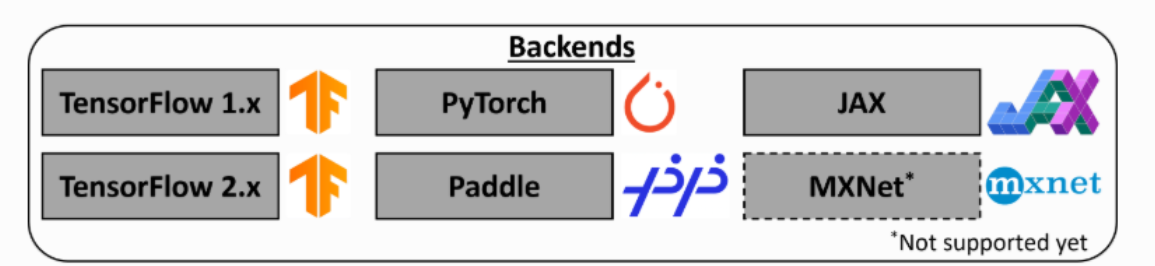
## ② 下半部分：Backends（深度学习后端）

说明 **DeepXDE 可用的计算后端**：

* TensorFlow 1.x / 2.x、PyTorch（主流、成熟）；
* Paddle、JAX（部分版本支持/进展中）；
* MXNet（图中标注 *Not supported yet*，尚未支持）。










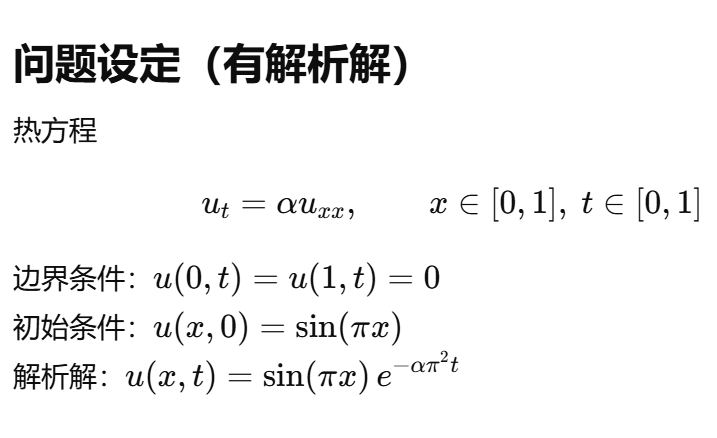

```python

# 1D Heat equation with DeepXDE
# u_t = alpha * u_xx on [0,1] x [0,1]
# u(x,0) = sin(pi x),  u(0,t)=u(1,t)=0

import deepxde as dde
import numpy as np

# 可复现
dde.config.set_default_float("float64")
dde.config.set_random_seed(42)

alpha = 0.1  # 热扩散系数

# ===== 1) 定义 PDE 残差 =====
def pde(X, u):
    # X = [x, t]
    u_t  = dde.grad.jacobian(u, X, i=0, j=1)     # du/dt
    u_xx = dde.grad.hessian(u,  X, i=0, j=0)     # d^2u/dx^2
    return u_t - alpha * u_xx

# ===== 2) 空间-时间区域 =====
geom = dde.geometry.Interval(0.0, 1.0)
timedomain = dde.geometry.TimeDomain(0.0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# ===== 3) 边界 & 初值 =====
def on_left_right(x, on_boundary):
    # 只在空间端点处施加边界条件（避免把 t=0/1 当成边界）
    return on_boundary and (np.isclose(x[0], 0.0) or np.isclose(x[0], 1.0))

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0.0, on_left_right)

ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(np.pi * x[:, 0:1]),    # u(x,0) = sin(pi x)
    lambda _, on_initial: on_initial,       # 只在 t=0 施加
)

# ===== 4) 采样配置（可调）=====
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=4000,      # 体点（空间-时间内部）
    num_boundary=400,     # 空间边界点
    num_initial=400,      # 初始面 t=0
)

# ===== 5) 神经网络 =====
# 输入维度=2（x,t），输出维度=1（u）
layer_size = [2] + [64, 64, 64, 64] + [1]
net = dde.nn.FNN(layer_size, "tanh", "Glorot normal")

model = dde.Model(data, net)

# ===== 6) 训练：先 Adam 再 L-BFGS =====
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=12000)

model.compile("L-BFGS")
losshistory, train_state = model.train()

# ===== 7) 评估：与解析解对比 =====
def true_solution(X):
    x = X[:, 0:1]
    t = X[:, 1:2]
    return np.sin(np.pi * x) * np.exp(-alpha * (np.pi ** 2) * t)

# 构造评估网格
xs = np.linspace(0, 1, 256)
ts = np.linspace(0, 1, 101)
XX, TT = np.meshgrid(xs, ts)
XT = np.hstack([XX.reshape(-1,1), TT.reshape(-1,1)])

u_pred = model.predict(XT)
u_true = true_solution(XT)

# L2 相对误差
rel_l2 = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true)
print("Relative L2 error on grid:", rel_l2)

# 如需保存/显示损失曲线
dde.saveplot(losshistory, train_state, issave=True, isplot=True)



```

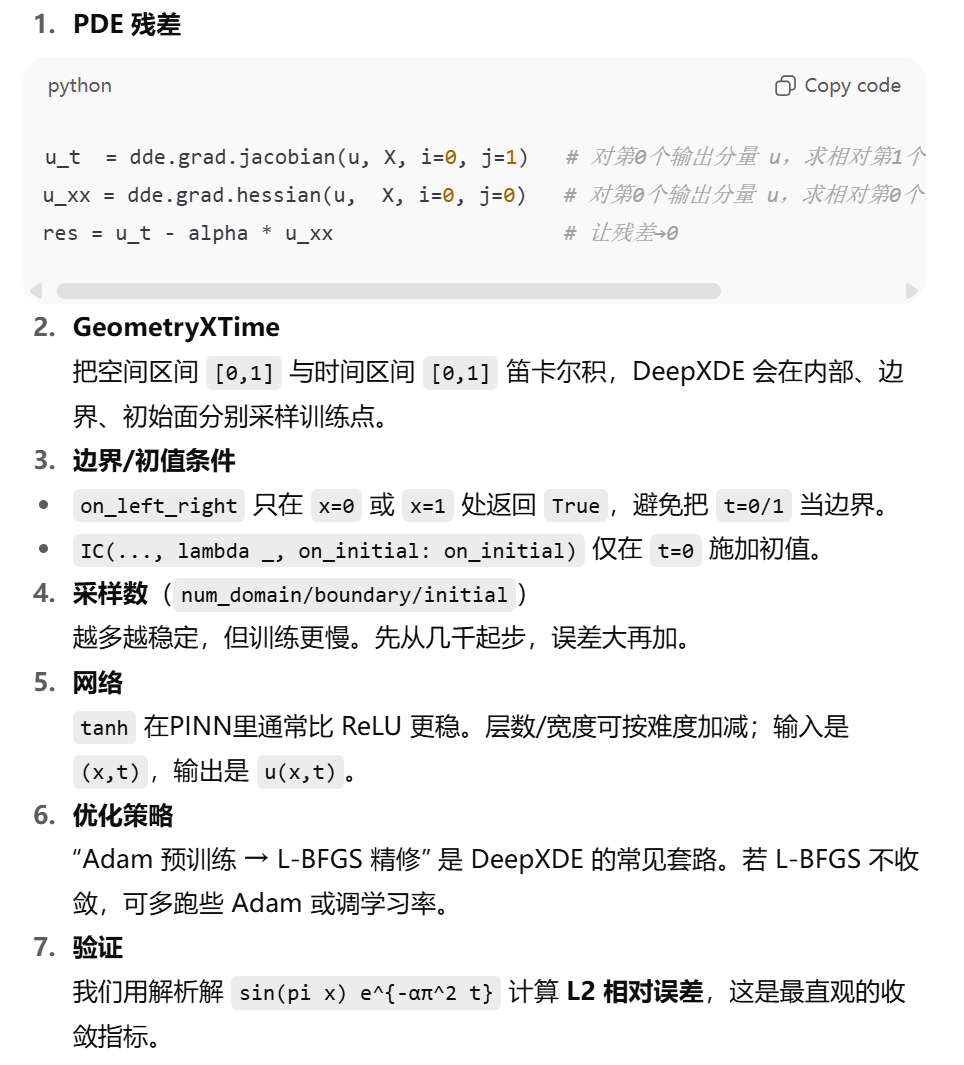



```python

import os, time, itertools, traceback
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

# ========= 可调超参搜索空间（先小再大） =========
ALPHA = 0.1
WIDTH_LIST  = [32, 64]          # 每层神经元个数
NLAYERS_LIST = [3, 4]           # 隐层层数（不含输入/输出层）
NDOMAIN_LIST = [1000, 3000]     # 域内采样点数（num_boundary/num_initial 按比例设）
ADAM_ITERS   = 8000             # Adam 迭代数（可按需要调整）
LR           = 1e-3             # Adam 学习率
SEED         = 42

OUTDIR = "exp_heat1d"
os.makedirs(OUTDIR, exist_ok=True)

dde.config.set_default_float("float64")
dde.config.set_random_seed(SEED)

# ========= 问题定义 =========
def pde(X, u):
    u_t  = dde.grad.jacobian(u, X, i=0, j=1)
    u_xx = dde.grad.hessian(u,  X, i=0, j=0)
    return u_t - ALPHA * u_xx

geom = dde.geometry.Interval(0.0, 1.0)
timedomain = dde.geometry.TimeDomain(0.0, 1.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def on_left_right(x, on_boundary):
    return on_boundary and (np.isclose(x[0], 0.0) or np.isclose(x[0], 1.0))

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0.0, on_left_right)
ic = dde.icbc.IC(
    geomtime,
    lambda x: np.sin(np.pi * x[:, 0:1]),
    lambda _, on_initial: on_initial,
)

def true_solution(X):
    x = X[:, 0:1]
    t = X[:, 1:2]
    return np.sin(np.pi * x) * np.exp(-ALPHA * (np.pi ** 2) * t)

# 评估网格（统一使用）
xs = np.linspace(0, 1, 256)
ts = np.linspace(0, 1, 101)
XX, TT = np.meshgrid(xs, ts)
XT_eval = np.hstack([XX.reshape(-1,1), TT.reshape(-1,1)])
U_true_eval = true_solution(XT_eval)

# ========= 工具函数 =========
def build_data(n_domain: int):
    n_boundary = max(200, n_domain // 10)
    n_initial  = max(200, n_domain // 10)
    return dde.data.TimePDE(
        geomtime, pde, [bc, ic],
        num_domain=n_domain,
        num_boundary=n_boundary,
        num_initial=n_initial,
    )

def build_net(width: int, nlayers: int):
    layer_size = [2] + [width] * nlayers + [1]
    net = dde.nn.FNN(layer_size, "tanh", "Glorot normal")
    return net, layer_size

def train_once(data, net, tag):
    model = dde.Model(data, net)

    # 记录 DeepXDE 的 losshistory 方便画图
    model.compile("adam", lr=LR, metrics=["l2 relative error"])
    t0 = time.time()
    lh1, ts1 = model.train(iterations=ADAM_ITERS, display_every=1000)
    adam_time = time.time() - t0

    # 可选：L-BFGS 精修
    lbfgs_time = None
    try:
        model.compile("L-BFGS")
        t1 = time.time()
        lh2, ts2 = model.train()
        lbfgs_time = time.time() - t1
        losshistory = lh1 + lh2  # 串起来
    except Exception as e:
        print(f"[WARN] L-BFGS failed for {tag}: {e}")
        traceback.print_exc()
        losshistory = lh1

    # 评估
    u_pred = model.predict(XT_eval)
    rel_l2 = np.linalg.norm(u_pred - U_true_eval) / np.linalg.norm(U_true_eval)

    # 保存 DeepXDE 的标准图
    dde.saveplot(losshistory, None, issave=True, isplot=False, output_dir=os.path.join(OUTDIR, tag))

    # 额外保存训练曲线（总 loss）
    plot_loss(losshistory, os.path.join(OUTDIR, tag, "loss_curve.png"))

    return rel_l2, adam_time, lbfgs_time

def plot_loss(losshistory, savepath):
    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    losses = [sum(v) for v in losshistory.loss_train]
    plt.figure()
    plt.plot(range(1, len(losses)+1), losses)
    plt.xlabel("Training steps (batches)")
    plt.ylabel("Total loss (physics + IC/BC)")
    plt.title("Training loss")
    plt.tight_layout()
    plt.savefig(savepath, dpi=200)
    plt.close()

# ========= 主程序：批量扫参 =========
def main():
    rows = []
    for width, nlayers, ndomain in itertools.product(WIDTH_LIST, NLAYERS_LIST, NDOMAIN_LIST):
        tag = f"w{width}_L{nlayers}_N{ndomain}"
        print(f"\n==== Running {tag} ====")
        data = build_data(ndomain)
        net, layer_size = build_net(width, nlayers)
        rel_l2, adam_t, lbfgs_t = train_once(data, net, tag)

        row = {
            "tag": tag,
            "width": width,
            "nlayers": nlayers,
            "num_domain": ndomain,
            "rel_L2": rel_l2,
            "adam_time_s": round(adam_t, 2),
            "lbfgs_time_s": None if lbfgs_t is None else round(lbfgs_t, 2),
            "total_params": int(sum(p.size for p in net.trainable_variables)),
        }
        rows.append(row)
        print(f"Result {tag}: rel_L2={rel_l2:.4e}, Adam {adam_t:.1f}s, L-BFGS {('NA' if lbfgs_t is None else f'{lbfgs_t:.1f}s')}")

        # 追加写 CSV（边跑边落地，防止中断没结果）
        write_csv(rows, os.path.join(OUTDIR, "results.csv"))

    print("\nAll done. Results saved to", os.path.join(OUTDIR, "results.csv"))

def write_csv(rows, path):
    import csv
    keys = ["tag","width","nlayers","num_domain","total_params","rel_L2","adam_time_s","lbfgs_time_s"]
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=keys)
        w.writeheader()
        for r in rows:
            w.writerow({k: r.get(k) for k in keys})

if __name__ == "__main__":
    main()


```

## 代码示例阅读


### 简单ODE系统

> 请注意，由于舍入误差，通常使用来dde.utils.isclose测试两个浮点值是否相等是明智的

```python
def boundary(x, on_initial):
    return dde.utils.isclose(x[0], 0)
```

### Lotka-Volterra 方程

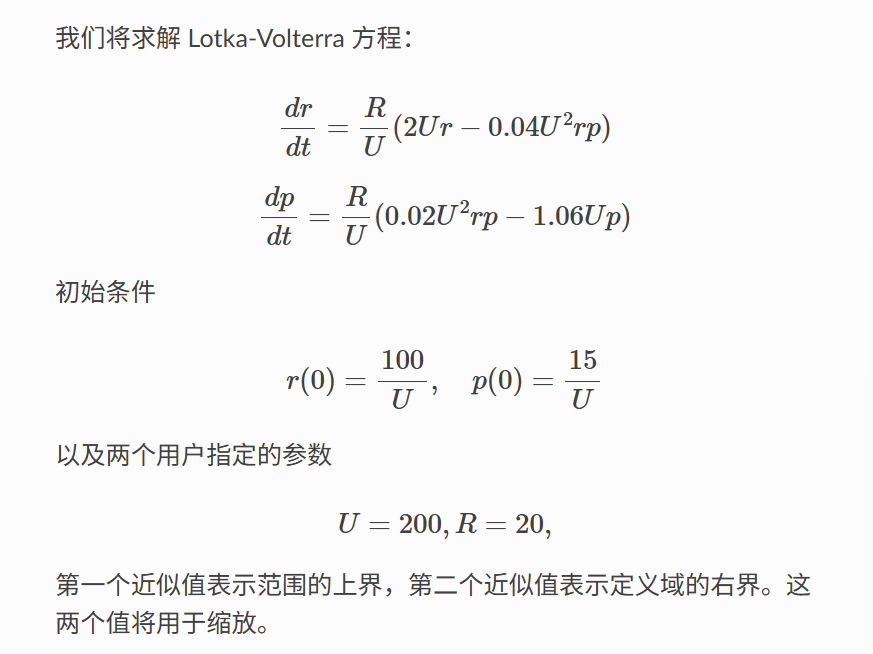


由于我们预期 Lotka-Volterra 方程具有周期性，因此我们添加一个特征层，sin(kt),这迫使预测具有周期性，因此更加准确。

```python
def input_transform(t):
    return tf.concat(
        (
            t,
            tf.sin(t),
            tf.sin(2 * t),
            tf.sin(3 * t),
            tf.sin(4 * t),
            tf.sin(5 * t),
            tf.sin(6 * t),
        ),
        axis=1,
    )
```


> 请注意，在求解该方程时，我们希望对初始条件有严格的约束，因此我们在创建网络时而不是作为 PDE 的一部分来定义它。
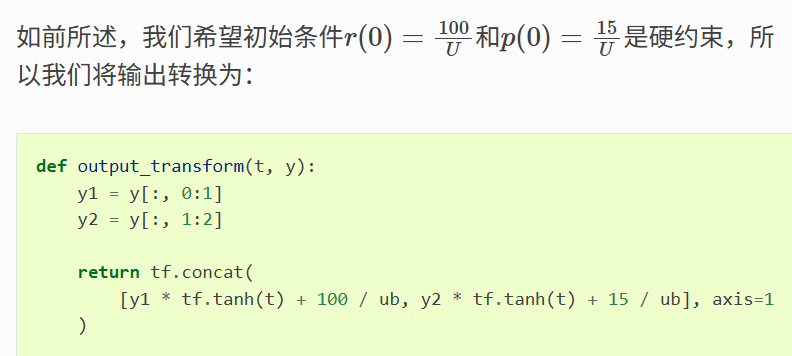

### 二阶ODE

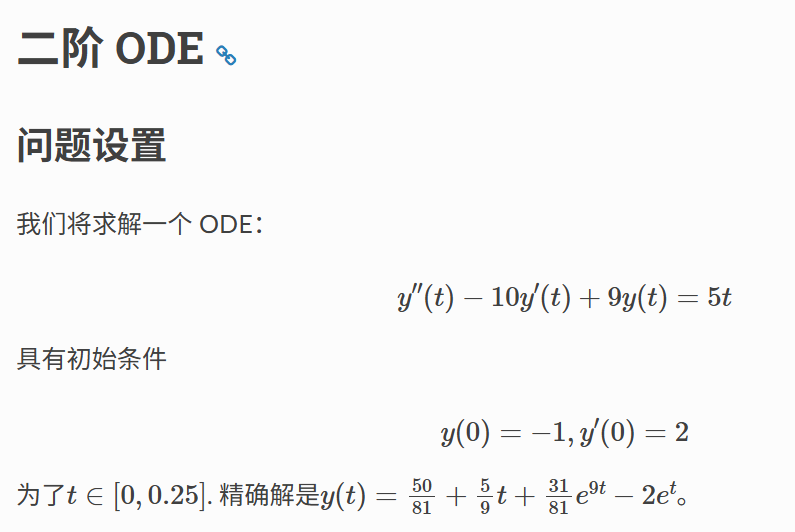



> 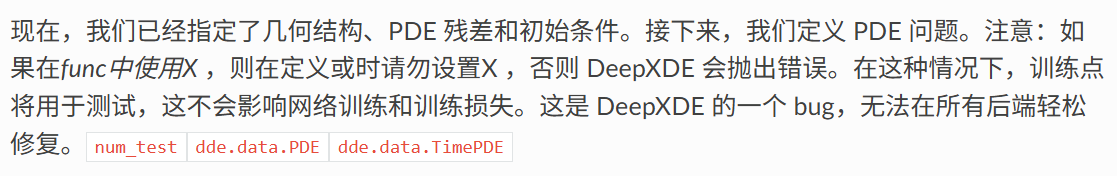
这段话说的是 DeepXDE 在 dde.data.PDE / dde.data.TimePDE 里有个已知小 bug：
当你把解析解/评估函数 func 传给 solution= 参数，而且 func 里直接用到了坐标 X（几乎都会用，比如 x = X[:,0:1]、t = X[:,1:2]），就不要再给数据集设置 num_test（或显式 X_test）。否则在某些后端会报错（形状/图构建相关），DeepXDE 只能退化为“用训练点做测试”。这不会影响训练和训练损失，只影响它内部如何取“测试点”。

```python
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic],
    num_domain=2000, num_boundary=200, num_initial=200,
    # num_test=1000,   # ❌ 若打开这行，某些后端会报错
    solution=exact      # ✅ 传了 func（exact）而且里面使用了 X
)
```



## 如何做好文献阅读